In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn import preprocessing 
import os 
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd 
import tensorflow 
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
import torch.optim as optim 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tamil
from tamil.utf8 import get_words
import unicodedata
# Tools for Tamil Text
from indicnlp.tokenize import indic_tokenize
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory
from transformers import BertTokenizer, BertModel

In [24]:
tamil_stopwords = set([
    "அங்கு", "அங்கே", "அடுத்த", "அதற்கு", "அதனால்", "அதன்", "அதிக", "அதில்", "அது", 
    "அதே", "அதை", "அந்த", "அந்தக்", "அந்தப்", "அல்லது", "அவரது", "அவர்", "அவர்கள்", 
    "அவள்", "அவன்", "அவை", "அன்று", "ஆகிய", "ஆகியோர்", "ஆகும்", "ஆனால்", "இங்கு", 
    "இங்கே", "இடத்தில்", "இடம்", "இதற்கு", "இதனால்", "இதனை", "இதன்", "இதில்", "இது", 
    "இதை", "இந்த", "இந்தக்", "இந்தத்", "இந்தப்", "இப்போது", "இரு", "இருக்கும்", "இருந்த", 
    "இருந்தது", "இருந்து", "இல்லை", "இவர்", "இவை", "இன்னும்", "உள்ள", "உள்ளது", "உள்ளன", 
    "உன்", "எந்த", "எல்லாம்", "என", "எனக்", "எனக்கு", "எனப்படும்", "எனவும்", "எனவே", 
    "எனினும்", "எனும்", "என்", "என்பது", "என்பதை", "என்ற", "என்று", "என்றும்", "என்ன", 
    "என்னும்", "ஏன்", "ஒரு", "ஒரே", "ஓர்", "கொண்ட", "கொண்டு", "கொள்ள", "சற்று", "சில", 
    "சிறு", "சேர்ந்த", "தவிர", "தனது", "தன்", "தான்", "நாம்", "நான்", "நீ", "பல", 
    "பலரும்", "பல்வேறு", "பற்றி", "பற்றிய", "பிற", "பிறகு", "பின்", "பின்னர்", "பெரும்", 
    "பேர்", "போது", "போல", "போல்", "போன்ற", "மட்டுமே", "மட்டும்", "மற்ற", "மற்றும்", 
    "மிக", "மிகவும்", "மீது", "முதல்", "முறை", "மேலும்", "மேல்", "யார்", "வந்த", 
    "வந்து", "வரும்", "வரை", "வரையில்", "விட", "விட்டு", "வேண்டும்", "வேறு"
])

In [21]:
def preprocess_tamil_english_text(text):
    # Remove special characters and numbers
    text = text.lower()
    
    text = re.sub(r'[^a-zA-Zஅஆஇஈஉஊஎஏஐஒஓௌகெஙடபணரஎழைசாௗ\s]', '', text)   
    
    tokens = text.split()
    
    # Remove stopwords (both Tamil and English)
    stop_words = set(stopwords.words('english')).union(tamil_stopwords)
    tokens = [word for word in tokens if word not in stop_words]
    
    return " ".join(tokens)

In [103]:
images_dir = 'images'

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('dev.csv')
test_df = pd.read_csv('test.csv')

train_text = train_df['transcriptions'].tolist()
train_labels = train_df['labels']
# train_image_id = train_df['image_id']

val_text = val_df['transcriptions'].tolist()
val_labels = val_df['labels']
# val_image_id = val_df['image_id']

test_text = test_df['transcriptions'].tolist()
test_image_id = test_df['image_id']

In [455]:
len(train_labels), len(val_labels), len(test_labels)

(1133, 284, 356)

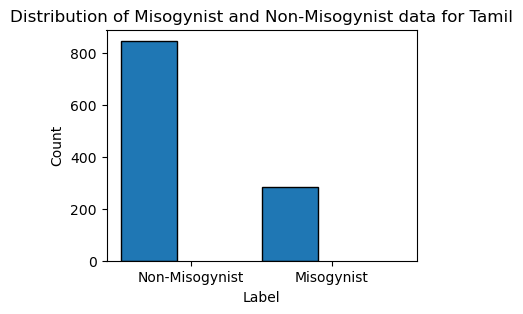

In [449]:
# Plotting the distribution of labels
plt.figure(figsize=(4, 3))
plt.hist(train_labels, bins=[-0.5, 0.5, 1.5], edgecolor='black', width=0.4)
plt.xticks([0, 1], ['Non-Misogynist', 'Misogynist'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Misogynist and Non-Misogynist data for Tamil')
plt.show()

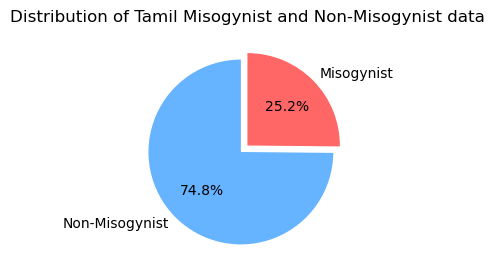

In [452]:
# Count occurrences of each label (0 and 1)
label_counts = train_labels.value_counts()

# Plotting the pie chart
plt.figure(figsize=(3, 3))
plt.pie(label_counts, labels=['Non-Misogynist', 'Misogynist'], autopct='%1.1f%%', colors=['#66b3ff','#ff6666'], startangle=90, explode=(0.1, 0)) 

# Adding title
plt.title('Distribution of Tamil Misogynist and Non-Misogynist data')
plt.show()

In [25]:
train_text = [preprocess_tamil_english_text(text) for text in train_text]
val_text = [preprocess_tamil_english_text(text) for text in val_text]
test_text = [preprocess_tamil_english_text(text) for text in test_text]

In [9]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")
model = AutoModel.from_pretrained("FacebookAI/xlm-roberta-base")
inputs = tokenizer(train_text, padding=True, truncation=True, return_tensors="pt", max_length=30)
val_input = tokenizer(val_text, padding=True, truncation=True, return_tensors="pt", max_length=30)
test_input = tokenizer(test_text, padding=True, truncation=True, return_tensors="pt", max_length=30)


c:\Users\nimmi\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
with torch.no_grad():
    train_features = model(**inputs).pooler_output 
    val_features = model(**val_input).pooler_output 
    test_features = model(**test_input).pooler_output

In [4]:
# np.save('train_features.npy', np.array(train_features))
# np.save('val_features.npy', np.array(val_features))
# np.save('test_features.npy', np.array(test_features))

train_features = np.load('train_features.npy')
val_features = np.load('val_features.npy')
test_features = np.load('test_features.npy')

In [5]:
train_features.shape, val_features.shape, test_features.shape

((1133, 768), (284, 768), (356, 768))

In [16]:
import torch
from transformers import ViTFeatureExtractor, ViTModel
from torchvision import transforms
from PIL import Image

# Load Vision Transformer (ViT) feature extractor and model once
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
model_vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
model_vit.eval()  # Set model to evaluation mode

# Preprocessing for images
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

# Function to extract image features
def extract_image_features(image_ids, images_dir):
    image_features = []
    
    for image_id in image_ids:
        image_path = os.path.join(images_dir, f"{image_id}.jpg")
        try:
            image = Image.open(image_path).convert("RGB")
            image = preprocess(image).unsqueeze(0)  # Add batch dimension
            
            # Extract features using ViT
            with torch.no_grad():
                outputs = model_vit(image)
                features = outputs.last_hidden_state.mean(dim=1).squeeze(0).numpy()  # Mean pooling
            image_features.append(features)
        except Exception as e:
            print(f"Error loading image {image_id}.jpg: {e}")
            image_features.append(None)
    
    return image_features


c:\Users\nimmi\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\nimmi\anaconda3\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Extract image features for train, validation, and test sets
train_image_features = extract_image_features(train_df['image_id'], images_dir)
val_image_features = extract_image_features(val_df['image_id'], images_dir)
test_image_features = extract_image_features(test_df['image_id'], images_dir)

In [3]:
# Save train, validation, and test image features to NumPy files
# np.save('train_image_features.npy', np.array(train_image_features))
# np.save('val_image_features.npy', np.array(val_image_features))
# np.save('test_image_features.npy', np.array(test_image_features))

# Load the saved image features from NumPy files
train_image_features = np.load('train_image_features.npy')
val_image_features = np.load('val_image_features.npy')
test_image_features = np.load('test_image_features.npy')


In [10]:
# Convert NumPy arrays to PyTorch tensors
train_image_features = torch.from_numpy(train_image_features)
val_image_features = torch.from_numpy(val_image_features)
test_image_features = torch.from_numpy(test_image_features)

# Convert NumPy arrays to PyTorch tensors
train_features = torch.from_numpy(train_features)
val_features = torch.from_numpy(val_features)
test_features = torch.from_numpy(test_features)

In [11]:
len(train_image_features)

1133

In [12]:
train_image_features[0].shape, val_image_features[0].shape, test_image_features[0].shape

(torch.Size([768]), torch.Size([768]), torch.Size([768]))

In [50]:
# test_image_features[0]

In [26]:
train_image_features[2].shape

(768,)

In [56]:
# Assuming train_image_features, val_image_features, test_image_features are DataFrames
train_image_features = train_image_features.values
val_image_features = val_image_features.values
test_image_features = test_image_features.values


In [60]:
import torch
train_image_features = torch.tensor(train_image_features)
val_image_features = torch.tensor(val_image_features)
test_image_features = torch.tensor(test_image_features)


In [62]:
train_image_features.shape

torch.Size([1133, 768])

In [13]:
train_image_features.shape, train_features.shape

(torch.Size([1133, 768]), torch.Size([1133, 768]))

COMBINE TEXT AND IMAGE FEATURES

In [14]:
# Combine image and text features into a single DataFrame
def combine_features(text_features, image_features):
    combined_features = torch.cat((text_features, image_features), dim=1)
    return combined_features 

In [15]:
# Combine features for train, validation, and test sets
train_combined_features = combine_features(train_features, train_image_features)
val_combined_features = combine_features(val_features, val_image_features)
test_combined_features = combine_features(test_features, test_image_features)

In [16]:
# Print the shape of combined features
print("Train combined features shape:", train_combined_features.shape)
print("Validation combined features shape:", val_combined_features.shape)
print("Test combined features shape:", test_combined_features.shape)

Train combined features shape: torch.Size([1133, 1536])
Validation combined features shape: torch.Size([284, 1536])
Test combined features shape: torch.Size([356, 1536])


In [17]:
import torch
import torch.nn as nn

class MultimodalClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MultimodalClassifier, self).__init__()
        
        # Shared subnetwork for both text and image features (since they are combined)
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # input_dim = 1536 (text + image features)
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.2)
        )
        
        # Final classification layer
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),  # output_dim = 1 for binary classification
            nn.Sigmoid()  # Sigmoid for binary classification
        )
    
    def forward(self, combined_features):
        # Pass combined features (text + image) through the network
        x = self.fc(combined_features)
        output = self.classifier(x)
        return output


In [127]:
# Convert combined features to tensors
# train_combined_features = torch.tensor(train_combined_features.values).float()
# val_combined_features = torch.tensor(val_combined_features.values).float()
# test_combined_features = torch.tensor(test_combined_features.values).float()

In [348]:
# Training function
def train_epoch(model, train_features, train_labels, optimizer, criterion):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(train_features)

    # Calculate loss
    loss = criterion(outputs.squeeze(), train_labels)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    predicted_labels = (outputs.squeeze() > 0.5).float()
    accuracy = accuracy_score(train_labels.cpu().numpy(), predicted_labels.cpu().numpy())
    
    return loss.item(), accuracy

# Evaluation function
def evaluate(model, val_features, val_labels, criterion):
    model.eval()
    
    with torch.no_grad():
        outputs = model(val_features)
        
        # Calculate loss
        loss = criterion(outputs.squeeze(), val_labels)
        
        # Calculate predicted labels
        predicted_labels = (outputs.squeeze() > 0.5).float()
        
        # Metrics calculation
        accuracy = accuracy_score(val_labels.cpu().numpy(), predicted_labels.cpu().numpy())
        precision = precision_score(val_labels.cpu().numpy(), predicted_labels.cpu().numpy())
        recall = recall_score(val_labels.cpu().numpy(), predicted_labels.cpu().numpy())
        f1 = f1_score(val_labels.cpu().numpy(), predicted_labels.cpu().numpy())
        
    return loss.item(), accuracy, precision, recall, f1


In [349]:
# Testing function
def test(model, test_features):
    model.eval()
    
    with torch.no_grad():
        outputs = model(test_features)
        
        # Convert outputs to predicted labels
        predicted_labels = (outputs.squeeze() > 0.5).float()
        
    return predicted_labels

In [407]:
# Example dimensions
input_dim = 1536  # Combined text and image features (768 + 768)
hidden_dim = 256  # Hidden dimension size 
output_dim = 1    # Binary classification (0 or 1)

# Initialize model
model = MultimodalClassifier(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5) #lr=0.001->69

train_labels1 = torch.tensor(train_labels.values).float()
val_labels1 = torch.tensor(val_labels.values).float()

In [414]:
num_epochs = 180
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(model, train_combined_features, train_labels1, optimizer, criterion)
    # print(f"Epoch [{epoch+1}/{num_epochs}]")
    # print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}") 
    val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate(model, val_combined_features, val_labels1, criterion)
    # print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")


In [415]:
test_labels = pd.read_csv('Tam_test_with_labels.csv')
test_labels = test_labels['labels']
test_labels1 = torch.tensor(test_labels.values).float()

In [416]:
from sklearn.metrics import classification_report
test_predictions = test(model, test_combined_features)
report = classification_report(test_labels, test_predictions, target_names=['Non-Misogynist', 'Misogynist'])
print(report)

                precision    recall  f1-score   support

Non-Misogynist       0.89      0.81      0.84       267
    Misogynist       0.54      0.70      0.61        89

      accuracy                           0.78       356
     macro avg       0.72      0.75      0.73       356
  weighted avg       0.80      0.78      0.79       356



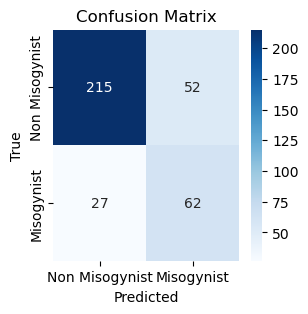

In [417]:
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Misogynist', 'Misogynist'], yticklabels=['Non Misogynist', 'Misogynist'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show() 

In [154]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


# test_labels = test_labels['labels']

# Scale features (important for KNN, SVM)
scaler = StandardScaler()
train_combined_features1 = scaler.fit_transform(train_combined_features)
test_combined_features1 = scaler.transform(test_combined_features)

# SVM
svm_model = SVC(kernel='rbf', C= 3, gamma= 'auto')
svm_model.fit(train_combined_features1, train_labels)
y_test_svm = svm_model.predict(test_combined_features1)
print("SVM Accuracy:", accuracy_score(test_labels, y_test_svm))
report = classification_report(test_labels, y_test_svm, target_names=['Non-Misogynist', 'Misogynist'])
print(report)

SVM Accuracy: 0.8342696629213483
                precision    recall  f1-score   support

Non-Misogynist       0.85      0.95      0.90       267
    Misogynist       0.76      0.49      0.60        89

      accuracy                           0.83       356
     macro avg       0.80      0.72      0.75       356
  weighted avg       0.83      0.83      0.82       356



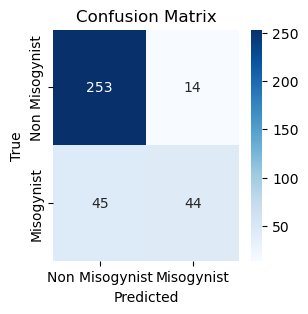

In [423]:
cm = confusion_matrix(test_labels, y_test_svm)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Misogynist', 'Misogynist'], yticklabels=['Non Misogynist', 'Misogynist'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show() 

In [182]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest
rf_model = RandomForestClassifier(n_estimators= 180, random_state=100, min_samples_split = 5, min_samples_leaf = 1, criterion = 'gini', max_features = 'sqrt')
rf_model.fit(train_combined_features1, train_labels)
y_pred_rf = rf_model.predict(test_combined_features1)
print("Random Forest Accuracy:", accuracy_score(test_labels, y_pred_rf))  
report = classification_report(test_labels, y_pred_rf, target_names=['Non-Misogynist', 'Misogynist'])
print(report)

Random Forest Accuracy: 0.8258426966292135
                precision    recall  f1-score   support

Non-Misogynist       0.82      0.99      0.90       267
    Misogynist       0.94      0.33      0.48        89

      accuracy                           0.83       356
     macro avg       0.88      0.66      0.69       356
  weighted avg       0.85      0.83      0.79       356



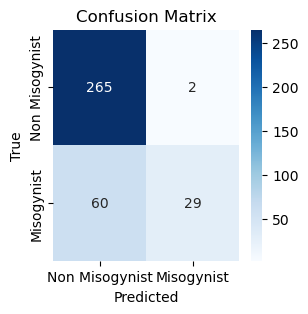

In [422]:
cm = confusion_matrix(test_labels, y_pred_rf)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Misogynist', 'Misogynist'], yticklabels=['Non Misogynist', 'Misogynist'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show() 

In [223]:
# KNN
knn_model = KNeighborsClassifier(n_neighbors=7, weights = 'uniform', algorithm = 'kd_tree', leaf_size = 2, p=2, metric='minkowski')
knn_model.fit(train_combined_features, train_labels)
y_pred_knn = knn_model.predict(test_combined_features)
report = classification_report(test_labels, y_pred_knn, target_names=['Non-Misogynist', 'Misogynist'])
print(report) 

                precision    recall  f1-score   support

Non-Misogynist       0.84      0.98      0.91       267
    Misogynist       0.89      0.44      0.59        89

      accuracy                           0.85       356
     macro avg       0.86      0.71      0.75       356
  weighted avg       0.85      0.85      0.83       356



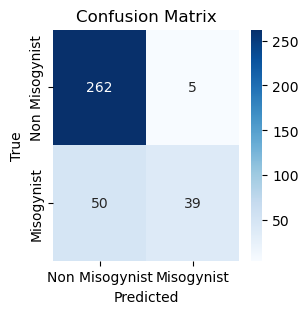

In [421]:
cm = confusion_matrix(test_labels, y_pred_knn)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Misogynist', 'Misogynist'], yticklabels=['Non Misogynist', 'Misogynist'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show() 

In [224]:
# Naive Bayes (not ideal for embeddings)
nb_model = GaussianNB()
nb_model.fit(train_combined_features, train_labels)
y_pred_nb = nb_model.predict(test_combined_features)
report = classification_report(test_labels, y_pred_nb, target_names=['Non-Misogynist', 'Misogynist'])
print(report)

                precision    recall  f1-score   support

Non-Misogynist       0.90      0.70      0.79       267
    Misogynist       0.47      0.78      0.58        89

      accuracy                           0.72       356
     macro avg       0.69      0.74      0.69       356
  weighted avg       0.79      0.72      0.74       356



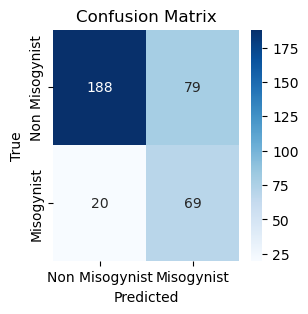

In [420]:
cm = confusion_matrix(test_labels, y_pred_nb)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Misogynist', 'Misogynist'], yticklabels=['Non Misogynist', 'Misogynist'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show() 

In [ ]:
train_combined_features1 = train_combined_features.reshape(train_combined_features.shape[0], 1, train_combined_features.shape[1])
val_combined_features1 = val_combined_features.reshape(val_combined_features.shape[0], 1, val_combined_features.shape[1])
test_combined_features1 = test_combined_features.reshape(test_combined_features.shape[0], 1, test_combined_features.shape[1])

In [273]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Assuming combined_embeddings is your input data, and labels are the targets
# combined_embeddings.shape -> (num_samples, time_steps, feature_dim)
# labels.shape -> (num_samples,)

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(train_combined_features1.shape[1], train_combined_features1.shape[2])),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='tanh'),  #tanh
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])


# Compile the Model
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Model
model.fit(train_combined_features1, train_labels, epochs=9, batch_size=128, validation_data=(val_combined_features1, val_labels))

Epoch 1/9


c:\Users\nimmi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.6921 - loss: 0.6056 - val_accuracy: 0.7394 - val_loss: 0.5685
Epoch 2/9
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7617 - loss: 0.5086 - val_accuracy: 0.7817 - val_loss: 0.5048
Epoch 3/9
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8059 - loss: 0.4506 - val_accuracy: 0.7852 - val_loss: 0.4981
Epoch 4/9
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8268 - loss: 0.4142 - val_accuracy: 0.7993 - val_loss: 0.4975
Epoch 5/9
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8366 - loss: 0.3678 - val_accuracy: 0.8169 - val_loss: 0.4879
Epoch 6/9
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8561 - loss: 0.3561 - val_accuracy: 0.8134 - val_loss: 0.4856
Epoch 7/9
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8663 - loss: 0.3433 - val_accuracy: 0.7958 - val_loss: 0.4645
Epoch 8/9
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8727 - loss: 0.3252 - val_accuracy: 0.8028 - val_loss: 0.4458
Epoch 9/9
9/9 ━━━

In [274]:
from sklearn.metrics import classification_report

# Predict and round off probabilities for binary classification 
y_pred_rnn = model.predict(test_combined_features1) 
y_pred_rnn = (y_pred_rnn > .5).astype(int)  

# Calculate and print metrics 
print(classification_report(test_labels, y_pred_rnn))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       267
           1       0.68      0.58      0.63        89

    accuracy                           0.83       356
   macro avg       0.77      0.75      0.76       356
weighted avg       0.82      0.83      0.82       356



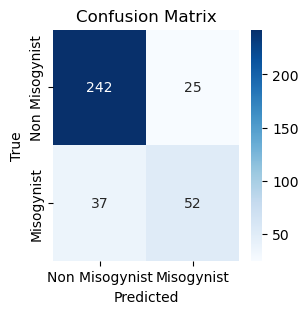

In [419]:
cm = confusion_matrix(test_labels, y_pred_rnn)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Misogynist', 'Misogynist'], yticklabels=['Non Misogynist', 'Misogynist'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show() 

In [228]:
print("Shape of train_combined_features:", train_combined_features1.shape)


Shape of train_combined_features: torch.Size([1133, 1, 1536])


In [275]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

In [276]:
# Define the GRU model
model = Sequential([
    GRU(128, return_sequences=True, input_shape=(train_combined_features1.shape[1], train_combined_features1.shape[2])),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(32, activation='tanh'),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
# print(model.summary())


c:\Users\nimmi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [320]:
# Train the model
history = model.fit(
    train_combined_features1, train_labels,
    validation_data=(val_combined_features1, val_labels),
    batch_size= 16,  # Adjust based on your system's resources
    epochs=9,
    verbose=1
)


Epoch 1/9
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9970 - loss: 0.0116 - val_accuracy: 0.8204 - val_loss: 0.9727
Epoch 2/9
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9965 - loss: 0.0169 - val_accuracy: 0.8204 - val_loss: 1.0198
Epoch 3/9
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9947 - loss: 0.0135 - val_accuracy: 0.8063 - val_loss: 1.0697
Epoch 4/9
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9923 - loss: 0.0215 - val_accuracy: 0.8239 - val_loss: 0.9657
Epoch 5/9
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9958 - loss: 0.0168 - val_accuracy: 0.8099 - val_loss: 1.0136
Epoch 6/9
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9865 - loss: 0.0285 - val_accuracy: 0.7993 - val_loss: 1.0143
Epoch 7/9
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9996 - loss: 0.0083 - val_accuracy: 0.8134 - val_loss: 1.0334
Epoch 8/9
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9946 - loss: 0.0175 - val_accuracy: 0.8063 - val_loss:

In [321]:
# Evaluate the model on the test set
y_pred = model.predict(test_combined_features1) 
y_pred_binary = (y_pred > 0.5).astype(int) 

# Print classification report  
print(classification_report(test_labels, y_pred_binary))  

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       267
           1       0.66      0.52      0.58        89

    accuracy                           0.81       356
   macro avg       0.75      0.71      0.73       356
weighted avg       0.80      0.81      0.80       356



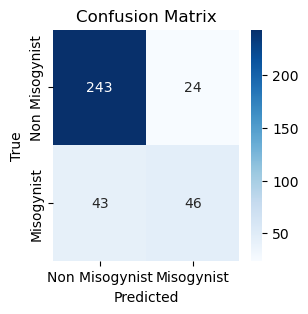

In [418]:
cm = confusion_matrix(test_labels, y_pred_binary)
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Misogynist', 'Misogynist'], yticklabels=['Non Misogynist', 'Misogynist'])
plt.xlabel('Predicted')  
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show() 